In [2]:
cd /home/dmoi/projects/foldtree2

/home/dmoi/projects/foldtree2


# Protein Structure Graph Construction and Analysis

This notebook demonstrates the process of converting protein structures (PDB files) into graph representations suitable for geometric deep learning. The workflow includes:

- Downloading and parsing PDB files using Bio.PDB.
- Extracting residue-level features, backbone and contact maps, bond angles, and other structural properties.
- Converting structures into PyTorch Geometric HeteroData objects for downstream machine learning tasks.
- Visualizing structural features such as Ramachandran plots.
- Preparing large datasets of protein structures for training graph neural networks.

The notebook leverages custom modules (e.g., `src.pdbgraph.PDB2PyG`) for feature extraction and graph construction, and supports efficient data loading and batching for large-scale experiments.

In [3]:
import wget
#download an example pdb file
filename = './1eei (1).pdb'
url = 'https://files.rcsb.org/download/1EEI.pdb'
#filename = wget.download(url)
datadir = '../../datasets/foldtree2/'

In [4]:
#use autoreload to reload modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys 
sys.path.append('/home/dmoi/projects/foldtree2')

In [6]:
from src import pdbgraph
import importlib
importlib.reload(pdbgraph)
converter = pdbgraph.PDB2PyG( 
aapropcsv = 'config/aaindex1.csv'
)

In [7]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pydssp
import tqdm
from Bio.PDB import PDBParser   
import numpy as np

14
103
<Chain id=D>
TPQNITDLCAEYHNTQIHTLNDKIFSYTESLAGKREMAIITFKNGATFQVEVPGSQHIDSQKKAIERMKDTLRIAYLTEAKVEKLCVWNNKTPHAIAAISMAN
    single_letter_code  Phi_Angle  Psi_Angle  Omega_Angle     0     1     2  \
0                    T   0.000000   0.000000     0.000000  4.35  0.05  0.84   
1                    T  -1.047017   2.663062    -3.141528  4.35  0.05  0.84   
2                    P  -1.903192  -0.014165    -3.122515  4.44  1.95  0.76   
3                    Q  -2.789905   2.943459    -3.097179  4.37  0.00  0.72   
4                    N  -1.061407  -0.663699    -3.112183  4.75  0.06  0.23   
..                 ...        ...        ...          ...   ...   ...   ...   
98                   A  -2.461680   2.534450     3.096931  4.35  0.61  1.18   
99                   I  -2.263589   2.385299    -3.135717  3.95  2.22  1.45   
100                  S  -2.224691   2.443919     3.118809  4.50  0.05  0.97   
101                  M  -2.760119   2.508907     3.122022  4.52  1.18  2.67   
102    

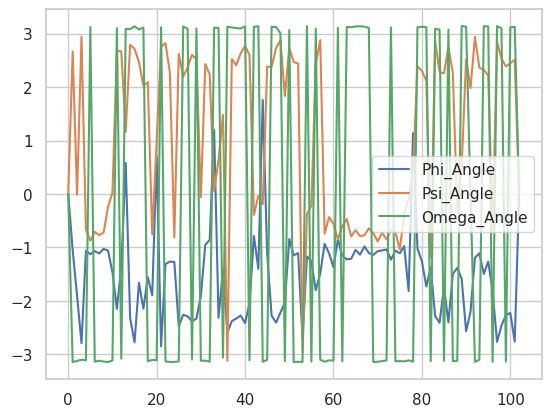

In [8]:
filename = 'config/1eei.pdb'
res  = converter.create_features(filename, distance = 10, verbose = False )
print(len(res))
angles, contact_points, springmat , hbond_mat, backbone , backbone_rev , positional_encoding , plddt , aa , bondangles , foldxvals , coords , window, windowrev = res
print( len(angles) )

#read the pdb file
parser = PDBParser()
structure = parser.get_structure('1eei', filename)
model = structure[0]

aa_dict = {
'ALA': 'A',
'ARG': 'R',
'ASN': 'N',
'ASP': 'D',
'CYS': 'C',
'GLN': 'Q',
'GLU': 'E',
'GLY': 'G',
'HIS': 'H',
'ILE': 'I',
'LEU': 'L',
'LYS': 'K',
'MET': 'M',
'PHE': 'F',
'PRO': 'P',
'SER': 'S',
'THR': 'T',
'TRP': 'W',
'TYR': 'Y',
'VAL': 'V'

}

#extract the sequence
seq = ''
chains = model.get_chains()
print(next(chains))
chain = next(chains)
for residue in chain:
	if PDB.is_aa(residue) and residue.get_resname() in aa_dict:
		seq += aa_dict[residue.get_resname()]
print(seq)
print(angles)


angles[['Phi_Angle', 'Psi_Angle' , 'Omega_Angle']].plot()
print( angles.isna().sum() )


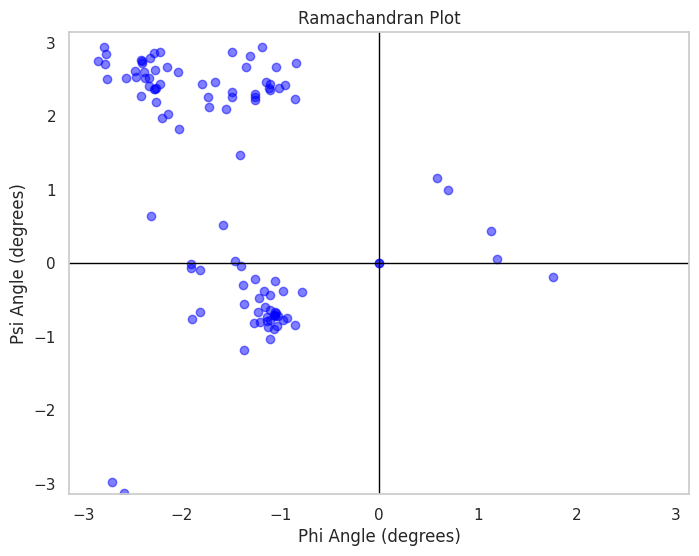

In [9]:
#plot ramachandran
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

plt.scatter(angles['Phi_Angle'], angles['Psi_Angle'], c='blue', alpha=0.5)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title('Ramachandran Plot')
plt.xlabel('Phi Angle (degrees)')
plt.ylabel('Psi Angle (degrees)')
plt.grid()
plt.show()

In [10]:
import multiprocessing as mp
import tqdm
import os
import numpy as np
import wget 
import pandas as pd


datadir = '../../datasets/'
cols = 'repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId'.split('_')
repdf = pd.read_table(datadir+ 'afdbclusters/2-repId_isDark_nMem_repLen_avgLen_repPlddt_avgPlddt_LCAtaxId.tsv')
repdf.columns = cols
print(repdf.head() , len(repdf))
def download_pdb(rep ,structdir = datadir+'structs/'):
	url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
	#check if file exists
	if os.path.exists( structdir + rep + '.pdb'):
		return structdir + rep + '.pdb'
	filename = wget.download(url, out=structdir + rep + '.pdb')
	return filename

def download(repdf , nreps = 100 , structdir = datadir +'structs/'):
	if not os.path.exists(structdir):
		os.makedirs(structdir)
	reps = repdf.repId.unique()
	if nreps:
		#select a random sample of representatives
		reps = np.random.choice(reps, nreps)
	with mp.Pool(20) as p:
		filenames = p.map(download_pdb, tqdm.tqdm(reps))
		return filenames
        


        repId  isDark  nMem  repLen   avgLen  repPlddt  avgPlddt  LCAtaxId
0  A0A6M1CKG1       0     3     122  122.667     96.06   88.1467     91347
1  A0A4Q3Q6P1       1     3     117  113.333     71.94   67.8333     80864
2  A0A4V3EFQ4       0     3     153  156.000     68.56   58.8533    131567
3  A0A4V3EKB1       1     3      51   51.000     62.62   62.7700      1883
4  A0A4V3EP89       0     2      96   94.500     70.88   72.1900   2593676 2302907


In [11]:
#download(repdf, nreps = 10000 , structdir = '../datasets/foldtree2/structs/' )

In [12]:
import torch
import os
import numpy as np
# Setting the seed for everything
torch.manual_seed(0)
np.random.seed(0)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
data_sample =converter.struct2pyg( filename, verbose=False )
print(data_sample)
ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]


HeteroData(
  identifier='1eei',
  AA={ x=[103, 20] },
  coords={ x=[103, 3] },
  R_true={ x=[103, 3, 3] },
  t_true={ x=[103, 3] },
  bondangles={ x=[103, 3] },
  plddt={ x=[103, 1] },
  positions={ x=[103, 256] },
  res={ x=[103, 857] },
  fourier1dr={ x=[103, 80] },
  fourier1di={ x=[103, 80] },
  fourier2dr={ x=[1, 1300] },
  fourier2di={ x=[1, 1300] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={
    edge_attr=[102],
    edge_index=[2, 205],
  },
  (res, backbonerev, res)={
    edge_attr=[102],
    edge_index=[2, 205],
  },
  (res, contactPoints, res)={
    edge_attr=[928],
    edge_index=[2, 928],
  },
  (res, hbond, res)={
    edge_attr=[106],
    edge_index=[2, 106],
  },
  (res, window, res)={
    edge_attr=[202],
    edge_index=[2, 202],
  },
  (res, windowrev, res)={
    edge_attr=[102],
    edge_index=[2, 102],
  },
  (res, informs, godnode)={ edge_index=[2, 103] },
  (godnode, informs, res)={ edge_index=[2, 103] },
  (res, informs, godno

In [14]:
print(data_sample['res'].x.shape)

torch.Size([103, 857])


In [15]:
import glob
datadir = '../../datasets/'

In [16]:
pdbfiles = glob.glob(datadir+'structs/*.pdb')
data_sample =converter.struct2pyg( pdbfiles[0], foldxdir=None) #)'./foldx/',  verbose=False)

print(data_sample)

HeteroData(
  identifier='A0A428ZB99',
  AA={ x=[180, 20] },
  coords={ x=[180, 3] },
  R_true={ x=[180, 3, 3] },
  t_true={ x=[180, 3] },
  bondangles={ x=[180, 3] },
  plddt={ x=[180, 1] },
  positions={ x=[180, 256] },
  res={ x=[180, 857] },
  fourier1dr={ x=[180, 80] },
  fourier1di={ x=[180, 80] },
  fourier2dr={ x=[1, 1300] },
  fourier2di={ x=[1, 1300] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={
    edge_attr=[179],
    edge_index=[2, 359],
  },
  (res, backbonerev, res)={
    edge_attr=[179],
    edge_index=[2, 359],
  },
  (res, contactPoints, res)={
    edge_attr=[1592],
    edge_index=[2, 1592],
  },
  (res, hbond, res)={
    edge_attr=[182],
    edge_index=[2, 182],
  },
  (res, window, res)={
    edge_attr=[356],
    edge_index=[2, 356],
  },
  (res, windowrev, res)={
    edge_attr=[179],
    edge_index=[2, 179],
  },
  (res, informs, godnode)={ edge_index=[2, 180] },
  (godnode, informs, res)={ edge_index=[2, 180] },
  (res, inform

In [17]:
#shuffle the data
np.random.shuffle(pdbfiles)
converter.store_pyg(pdbfiles[0:5000], filename='structs_traininffttest.h5', foldxdir = None, verbose = False)

100%|███| 5000/5000 [51:28<00:00,  1.62it/s]


In [18]:

from torch_geometric.data import DataLoader
from torch_geometric.data import Batch

#load the dataset
struct_dat = pdbgraph.StructureDataset('structs_traininffttest.h5')

train_loader = DataLoader(struct_dat, batch_size=20, shuffle=True , worker_init_fn = np.random.seed(0) , num_workers=4 )
#test out the dataloader
for i, data in enumerate(train_loader):
	print(i)
	print(data)
	if i > 10:
		break


0
HeteroDataBatch(
  identifier=[20],
  AA={
    x=[6058, 20],
    batch=[6058],
    ptr=[21],
  },
  R_true={
    x=[6058, 3, 3],
    batch=[6058],
    ptr=[21],
  },
  bondangles={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  coords={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  fourier1di={
    x=[6058, 80],
    batch=[6058],
    ptr=[21],
  },
  fourier1dr={
    x=[6058, 80],
    batch=[6058],
    ptr=[21],
  },
  fourier2di={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  fourier2dr={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  godnode={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  godnode4decoder={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  plddt={
    x=[6058, 1],
    batch=[6058],
    ptr=[21],
  },
  positions={
    x=[6058, 256],
    batch=[6058],
    ptr=[21],
  },
  res={
    x=[6058, 857],
    batch=[6058],
    ptr=[21],
  },
  t_true={
    x=[6058, 3],
    batch=[6058],
    ptr=[21],
  },
  (godnode4decoder, informs

In [19]:
pdbfiles_structalign = glob.glob(datadir + 'struct_align/*/structs/*.pdb')

In [ ]:
converter.store_pyg(pdbfiles_structalign, filename='structalignFFT.h5', verbose = False)

100%|█| 45853/45853 [8:38:59<00:00,  1.47it/
